# Introduction

La transformée de Fourier rapide (FFT) permet de multiplier quasiment linéairement par rapport au degré $d$ du polynôme de plus haut degré (la complexité est en $\mathscr{O}\left( d \log (d) \log \log (d)\right)$).

Ce procédé utilise cependant le groupe des racines $2^k$-ièmes de l'unité, ce qui ne pose pas de problème dans $\mathbb{C}$ qui est de caractéristique nulle. Si $\mathbb{F}$ est un corps de caractéristique $p$, on peut observer que $\forall x, \, y \in \mathbb{F}, \, \forall k \in \mathbb{N}, \, \left(x + y \right)^{p^k}$, donc le polynôme $X^{p^k} - 1$ s'écrit aussi $(X-1)^{p^k}$, donc il n'y a qu'une racine $p^k$-ième de l'unité et en particulier une racine $2^k$-ième de l'unité . Le but de ce document est donc de trouver une alternative à la tranformée rapide de Fourier rapide pour la multiplication à travers les sous-groupes additifs de $\mathbb{F}$.

L'utilité de cette méthode réside principalement dans l'utilisation des codes correcteurs, qui manipulent des objets de $\mathbb{F}_2$ ou $\mathbb{F}_{2^n}$, notamment pour les codes de Reed-Solomon ou les codes cycliques.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from time import time
from tqdm import tqdm

# Sous-groupes additifs de $\mathbb{F_{2^n}}$

## Polynômes linéarisés

<u>*Définition*</u> : Soit $\mathbb{F}$ un corps de caractéristique $p$, soit $f \in \mathbb{F}[X]$, on dit que $f$ est linéarisé, s'il vérifie une des assertions équivalentes:
- Tous les monômes de $f$ sont de degré une puissance de $p$.
- L'application ${}^t \! f : g \longmapsto f \circ g$ est un endomorphisme du $\mathbb{F}_p$-espace vectoriel $\mathbb{F}[X]$.

Preuve:  
$\implies$: Soit $k \in \mathbb{N}$, soit $ \lambda \in \mathbb{F}_p, \, g,h \in \mathbb{F}[X], \, (\lambda g + h)^{p^k} = \lambda^{p^k} g^{p^k} + h^{p^k} = \lambda g^{p^k} + h^{p^k}$. Donc pour tout $k \in \mathbb{N}$, l'application associée à $X^{p^k}$ est donc linéaire. Par linéarité, on obtient donc la deuxième propriété.  
$\Longleftarrow$: Si ${}^t \! f$ est $\mathbb{F}_p$-linéaire, en posant $f = \sum\limits_{k = 0}^d a_k X^k$, on a $\forall x \in \mathbb{F}, \, \lambda \in \mathbb{F}_p, \, \lambda \sum\limits_{k = 0}^d a_k X^k = \lambda f(X) = \lambda {}^t \! f(X) = {}^t \! f(\lambda X) = f(\lambda X) = \sum\limits_{k = 0}^d a_k \lambda^k X^k = $. Donc $\forall \lambda \in \mathbb{F}_p, \, \forall k \leqslant d, \, a_k (\lambda^k - \lambda) = 0$, donc $a_k = 0$ ou le polynôme $X^k-X$ admet les p racines de $F_p$ donc $p | k$ ou $k = 1$. Si $k \neq 1$, on peut réitérer avec $\frac{k}{p}$, car $\lambda^k = \lambda^\frac{k}{p}$. On a ainsi montré que si $a_k$ n'est pas nul, $k$ est une puissance de p.

*Corollaire:* Si $f$ est un polynôme linéarisé de $\mathbb{F}$, alors l'application polynômiale induite est un endomorphisme du $\mathbb{F}_p$-espace vectoriel $F_p$.

***Théorème***: Soit $w \in F[X]$ scindé à racines simples, alors $w$ est linéarisé si et seulement si le groupe de ses racines est un sous-groupe additif de $\mathbb{F}$.

Preuve:  
$\implies$ Si $w$ est linéarisé, l'application polynômiale induite $\tilde{w}$ est $\mathbb{F}_p$-linéaire, donc $\mathscr{V} (w) = \ker w$ qui est un sous-espace vectoriel de $\mathbb{F}$, donc un sous-groupe additif de $\mathbb{F}$.  
$\Longleftarrow$ Si $G := \mathscr{V} (w) \leqslant \mathbb{F}$, on note $c$ son coefficient dominant. Pour $\lambda \in \mathbb{F}_p^{\times}, \, x \in \mathbb{F},$  
$$w(\lambda x) = c \prod\limits_{\alpha \in G} (\lambda x-\alpha) = c \prod\limits_{\alpha \in\lambda^{-1}G} \lambda(x-\alpha) = \lambda^d c \prod\limits_{\alpha \in G} (x-\alpha) = \lambda^d w(x)$$
On a également $w(0 \cdot x) = w(0) = 0$ car $G$ est un groupe additif. De plus comme $w$ est scindé à racines simples, $d \leqslant \# \mathbb{F}$, donc $\forall \lambda \in \mathbb{F}_p, w(\lambda X) = \lambda^d w(X)$.  
Montrons maintenant que $d = p^m$ pour un certain $m$. On note $H$ l'espace vectoriel engendré par $G$ (qui est en réalité $G$ lui-même). $H$ est de cardinal $p^n$ pour un certain $n \in \mathbb{N}$ car $H$ est un $\mathbb{F}_p$-espace vectoriel de dimension finie, donc comme $G \leqslant H$, d'après le théorème de Lagrange, $d|p^n$, et comme $p$ est premier, $\exists m \in \mathbb{N}$ tq $d = p^m$. Donc $\forall \lambda \in \mathbb{F}_p, \, w(\lambda X) = \lambda w(X)$ On peut ensuite conclure en utilisant la même mécanique que dans la preuve précédente. 

## Association drapeau-suite ordonnée de polynômes linéarisés

Avec un tel polynôme unitaire $w$, on a alors un espace vectoriel $W = \mathscr{V} (w)$, cet espace est de dimension $m$, il admet donc une base $(\beta_1, \dots \beta_m)$, qui vérifie $W = \bigoplus\limits_{k = 1}^m \langle \beta_k \rangle$. On pose alors $W_i = \bigoplus\limits_{k = 1}^i \langle \beta_k \rangle$, la suite $(W_i)$ est associée à une suite de polynômes unitaires linéarisés $w_i$ d'après le théorème précédent. On a alors une suite ordonnée, car l'inclusion croissante des $W_i$ implique que $X = w_0 | w_1 | \cdots | w_n = w$.

### Drapeau canonique

L'objectif est donc de se créer un drapeau efficace sur $\mathbb{F}$ grâce à une suite ordonnée de polynômes scindés à racines simples. On supposera dorénavant $\mathbb{F} = \mathbb{F}_{p^n}$.

Construisons la suite de polynômes $(s_i)_{i \in \mathbb{N}}$ par $s_0 = X$ et $\forall i \in \mathbb{N}, \, s_{i+1} = s_i^p - s_i$.

On remarque rapidement plusieurs propriétés utiles:
- $s_{i+1} = s_i(s_i^{p-1} - 1)$ donc $s_i | s_{i+1}$
- $s_{i+1} = s_1 \circ s_i$ donc $s_{i+j} = s_i \circ s_j$
- $s'_{i+1} = p s'_i s_i^{p-1} - s'_i = -s'_i$ donc comme $s_0$ est à racines simples, tous les $s_i$ le sont.
- $s_{i+1} = s_i (s_i - 1) \cdots (s_i - (p-1)) =  s_i (s_i + 1) \cdots (s_i + (p-1))$
- Les $s_i$ sont tous des polynômes linéarisés.

Observons maintenant une propriété de récurrence qui témoigne du peu de coefficients non nuls des $s_i$.  
Pour tout $\nu \in \mathbb{N}$, on pose $\mathcal{P}_\nu$: "$s_{p^\nu} = X^{p^{p^\nu}} - X$".
- *Initialisation*: $s_{p^0} = s_1 = X^p - X = X^{p^{p^0}} - X$
- *Hérédité*: Si $\mathcal{P}_\nu$ est vraie, $s_{p^{\nu +1}} = s_{p \cdot p^{\nu}} = s_{p^\nu} \circ \cdots \circ s_{p^\nu} 
= (X^{p^{p^\nu}} - X) \circ \cdots \circ (X^{p^{p^\nu}} - X)$ 
$= (X^{p^{p^\nu}} - X) \circ \cdots \circ ((X^{p^{p^\nu}} - X)^{p^{p^\nu}} - (X^{p^{p^\nu}} - X) 
= (X^{p^{p^\nu}} - X) \circ \cdots \circ (X^{p^{2p^\nu}} - 2X^{p^{p^\nu}} +  X)$  
$= (X^{p^{p^\nu}} - X) \circ \cdots \circ ( (X^{p^{2p^\nu}} - 2X^{p^{p^\nu}} +  X)^{p^{p^\nu}} - (X^{p^{2p^\nu}} - 2X^{p^{p^\nu}} +  X))
= (X^{p^{p^\nu}} - X) \circ \cdots \circ ( X^{p^{3p^\nu}} - 3X^{p^{2p^\nu}} + 3X^{p^{p^\nu}} - X)$  
$= \cdots = X^{p^{p\cdot p^\nu}} - pX^{p^{(p-1)p^\nu}} + \cdots + (-1)^{p-2} pX^{p^{2p^\nu}} + (-1)^{p-1} pX^{p^{p^\nu}} + (-1)^p X$  
$ = X^{p^{p^{\nu+1}}} - X$

Donc $\forall \nu \in \mathbb{N},  \, s_{p^\nu} =  X^{p^{p^\nu}} - X$.

Nous avons donc une suite adéquate de polynômes de $\mathbb{F}_p [X]$ avec de bonnes propriétés pour les indices qui sont des puissances de $p$. Ainsi on définira $\mathbb{F}_{p^n}$ avec $n = 2^\nu$. On aura alors $\mathbb{F}_{p^n} = \mathscr{V}(s_n)$.

In [2]:
p = 2
nu = 3
n = p**nu
F = GF(p)
R.<X> = PolynomialRing(F,'X')

In [3]:
def drapeau_canonique (k):
    s = X # On initialise s_0
    liste_pol = [X]
    for i in range(k):
        s = s**p - s # simple propriété de récurrence
        liste_pol.append(s) # on ajoute le dernier s_i calculé
    return liste_pol

In [4]:
drapeau = drapeau_canonique(n) # On calcule notre suite de polynômes
s = drapeau[n] # On garde s_n sous le coude
K.<a> = GF(p**n, name='a') # On définit notre corps F_{p^n}

On peut vérifier informatiquement la dernière propriété énoncée des $s_{p^\nu}$.

In [5]:
print([drapeau[p**i] for i in range(nu+1)])

[X^2 + X, X^4 + X, X^16 + X, X^256 + X]


## Technique de remontée-descente en cascade pour la multiplication des polynômes

In [6]:
f = X**150 + X**109 + X**56 + X**34 + X
g = X**67 + X**45 + X**39 + X**34 + X**24 + X**11 + 1

Le principe sous-jacent de cette méthode est différent de la méthode de multiplication algébrique des polynômes. Si $f$ et $g$ sont deux polynômes de degré $d < p^i \leqslant p^n$ il y a 3 étapes pour cela:
- On évalue $f$ et $g$ sur $W_i$
- On multiplie terme à terme les $f(\alpha) g(\alpha)$ pour $\alpha \in W_i$
- On interpole les points obtenus pour obtenir $fg$.

Bien évidemment, effectué de façon naïve, cet algorithme a une complexité peu intéressante. En effet pour l'interpolation, nous avons besoin d'une complexité quadratique, ce qui n'apporte rien par rapport à la mutliplication algébrique.  
Il faut donc se reposer sur un théorème très utile lorsque l'on travaille dans des anneaux: le théorème des restes chinois. Il stipule que si nous avons une famille $(\mathscr{I}_0, \dots , \mathscr{I}_q)$ d'idéaux d'un anneau $A$, deux à deux premiers entre eux, il y a un isomorphisme canonique décrit ci dessous
$$ A/(\mathscr{I}_0 \cdots \mathscr{I}_p) \longrightarrow A/\mathscr{I}_0 \times \cdots \times A/ \mathscr{I}_p $$
On sait par ailleurs que pour $alpha \in \mathbb{F}_{2^n}$, si $\beta, \beta +1, \dots , \beta + p-1$ sont les $p$ racines simples de $s_1 - \alpha$, alors $s_{i+1} - \alpha = (s_i - \beta) (s_i - \beta -1) \cdots (s_i - \beta - p+1)$, il suffit de remplacer $s_i$ par $X$ pour s'en convaincre.  
Le théorème des restes chinois nous indique donc que l'on a un isomorphisme canonique entre $\mathbb{F}[X] / \langle s_{i+1} - \alpha \rangle$ et $\mathbb{F}[X] / \langle s_{i} - \beta \rangle \times \mathbb{F}[X] / \langle s_{i} - \beta -1 \rangle \times \cdots \times \mathbb{F}[X] / \langle s_{i} - \beta - p +1\rangle$  
Comment appliquer cette propriété afin d'atteindre notre but? Il convient d'observer deux résultats agréables:
- La restriction à $\mathbb{F}_{2^i -1} [X]$ de la projection sur $\mathbb{F}[X]/\langle s_i - \alpha \rangle$ est un isomorphisme canonique.
- Grâce au théorème des noyaux sur le morphisme d'évaluation, on a un autre isomorphisme canonique entre $\mathbb{F}[X]/\langle s_O - \alpha \rangle$ et $\{ f(\alpha), \, f \in \mathbb{F} [X] \}$.

Pour évaluer $f$ sur $W_i + \alpha$, il suffit alors d'étudier $f \mod s_i - \alpha$, il suffit alors d'écrire un algorithme récursif qui nous donne $f \mod s_i - \alpha$ évalué sur $W_i$ pour $i$ et $\alpha$ fixés:
- si $i = 0, \, f \mod s_0 - \alpha = f \mod X- \alpha = f(\alpha)$
- sinon pour chaque racine $\beta + j$, on calcule $f \mod s_{i-1} - (\beta + j)$ et on l'évalue sur $W_{i-1}$, cela nous donne le résultat escompté car $W_i + \alpha = \bigsqcup\limits_{j = 0}^{p-1} W_{i-1} + \beta + j$.  
Ce raisonnement nous donne l'algorithme ci dessous pour évaluer $f$ sur $W_i$.

In [7]:
def descente_rec_p (f,i):
    """Algorithme d'évaluation de f en cascade pour le cas de caractéristique p quelconque"""
    
    def descente_aux (f,j,alpha):
        """Fonction auxiliaire par récurrence qui nous donne f mod (s_i - alpha) évalué pour tout alpha dans W_i"""
        
        if j == 0: # Cas où l'on arrive en bas de la cascade
            return [(alpha,f)] # f mod (s_0 - alpha) vaut exactement f(alpha)
        
        else: # Cas où il nous reste des étages à descendre
            liste = [] # la liste stockera les f(alpha) dedans
            Beta = (X**p - X - alpha).roots(K,multiplicities=False) # on calcule les beta qui vérifient s_1(beta) = alpha
            for beta in Beta: # chaque étape le boucle sera réalisée puis concaténée
                liste += descente_aux(f%(drapeau[j-1] - beta),j-1,beta) # On concatène la liste obtenue pour f mod (s_{i-1} - beta) pour chaque racine
            
            return liste
    
    return descente_aux(f%drapeau[i],i,0) # il ne nous restait qu'à l'utiliser sur f = f mod s_i

In [8]:
liste_f = descente_rec_p (f,n)
liste_g = descente_rec_p (g,n)

De la façon dont l'algorithme est fait, on constate que la liste des $f(\alpha), \, \alpha \in W_i$ est la concaténation de $p$ sous-listes qui sont les évaluations de $f$ sur les $f(\alpha + j),\, \alpha \in W_{i-1}, \, j <p$. Cette construction va nous permettre d'interpoler.  
En effet, si l'on connaît $f \mod s_i - \beta - j$ pour chaque $j <p$, la formule d'interpolation  est 
$$ f \mod s_i - \alpha = - \sum \limits_{j = 0}^{p-1} (f  \mod s_{i-1} - \beta -j) \cdot \prod\limits_{k \neq j} (s_{i-1} - \beta - k) = - \sum \limits_{j = 0}^{p-1} \frac{s_i - \alpha}{s_{i-1} - \beta - j} \cdot (f \mod s_{i-1} - \beta -j) $$.
Cela se remarque en notant que $1 \cdot 2 \cdots (p-1) = \prod\limits_{k \in \left. \mathbb{Z}/ p\mathbb{Z} \right.^\times} k =  \prod\limits_{j = 1}^{p-1} g^j = g^{\sum\limits_{j = 1}^{p-1}} = g^{\frac{p (p-1)}{2}} = g^{\frac{p-1}{2}} = -1$, où $g$ est un générateur du groupe multiplicatif cyclique $\left. \mathbb{Z}/ p\mathbb{Z} \right.^\times$.  
Ceci nous donne l'algorithme suivant.

In [9]:
def remontee_rec_p (liste_f):
    """Algorithme d'interpolation de f en cascade pour le cas de caractéristique p quelconque"""
    
    def remontee_aux (liste_f,i):
        """Fonction auxiliaire par récurrence qui nous donne f mod (s_i - alpha) évalué pour tout alpha dans W_i"""
        k = len(liste_f)
        
        if k == 1: # Cas où l'on arrive en bas de la cascade
            return liste_f[0] # Dans ce cas il suffit de renvoyer (alpha,f)
        
        else: # Cas où il nous reste des étages à descendre
            lis_ff = [] # servira à stocker les valeurs (beta, f mod (s_{i-1} - beta))
            l = k//p # taille de la tranche de liste qui servira pour chaque racine beta
            
            for j in range(p):
                lis_ff.append(remontee_aux(liste_f[j*l:(j+1)*l], i-1)) # tranche de liste associée à chaque racine beta
            ss = drapeau[i] # vaut s_i
            sss = drapeau[i-1] # vaut s_{i-1}
            alpha = (lis_ff[0][0])**p - lis_ff[0][0] # calcul du alpha qui vérifie pour chaque beta, s_1(beta) = alpha
            f = - sum([ lis_ff[j][1]*(ss-alpha)//(sss-lis_ff[j][0]) for j in range(p) ]) % (ss - alpha) # formule d'interpolation (inverse du théorème chinois)
            
            return (alpha, f) # On renvoie le résultat obtenu sous forme d'un couple pour garder un alpha en mémoire
    
    return remontee_aux(liste_f,n)[1] # seul f nous importe

In [10]:
remontee_rec_p (liste_f)

X^150 + X^109 + X^56 + X^34 + X

Il suffit alors de coder un algorithme de multiplication terme à terme pour deux listes de la forme $[ (\alpha,f(\alpha)), \, \alpha \in W_i$ puis d'enchainer les trois étapes.

In [11]:
def produit_listes (liste_f, liste_g):
    m = len(liste_f)
    return [(liste_f[i][0], liste_f[i][1] * liste_g[i][1]) for i in range(m)]

In [51]:
def multiplication_rec_p (f,g):
    if f.degree() + g.degree() < 1:
        m = 0
    else:
        m = floor(log(f.degree() + g.degree(),p))+1
    lis_f = descente_rec_p (f,m)
    lis_g = descente_rec_p (g,m)
    lis_fg = produit_listes (liste_f,liste_g)
    return remontee_rec_p(lis_fg)

In [13]:
multiplication_rec_p(f,g) == f*g

True

Or toutes ces étapes sont répétitives inutilement, on peut tout exécuter d'un coup, avec une petite modification:

In [50]:
def produit_rec_p (f,g):
    """Algorithme de multiplication de f et g en cascade pour le cas de caractéristique p"""
    if f.degree() + g.degree() < 1:
        m = 0
    else:
        m = floor(log(f.degree() + g.degree(),p))+1
    def produit_aux (f,g,i,alpha):
        if i == 0:
            return f*g
        else:
            Beta = (X**p - X - alpha).roots(K, multiplicities = False)
            ss = drapeau[i]
            sss = drapeau[i-1]
            return sum( [ ((alpha - ss)//(sss-beta))*produit_aux(f%(sss - beta),g%(sss - beta),i-1,beta) for beta in Beta ] ) % (ss - alpha)
    return produit_aux(f,g,m,0)

In [15]:
produit_rec_p(f,g) == f*g

True

On peut également remarquer qu'on calcule beaucoup de racines de polynômes, alors qu'elles sont combinaisons linéaires de $n$ racines successives des polynômes $X^p - X - \alpha_i$, on peut alors modifier le programme pour tout effectuer après calcul de ces racines en amont.

In [16]:
V = VectorSpace(F,n)
M = MatrixSpace(F,n, sparse = True)
Alpha = [1]
D = copy(M.zero())
unite = copy(V.zero())
unite[0] = 1
for i in range(n-1):
    D[i+1,i] = 1
for i in range(n-1):
    Alpha.append(((X**p-X-Alpha[i]).roots(K,multiplicities = False))[0])
vec_alpha = vector(Alpha)

In [17]:
def produit_eff_p (f,g):
    """Algorithme de multiplication de f et g en cascade pour le cas de caractéristique p"""
    if f.degree() + g.degree() < 1:
        m = 0
    else:
        m = floor(log(f.degree() + g.degree(),p))+1
    def produit_aux (f,g,i,x_alpha):
        if i == 0:
            return f*g
        else:
            x_beta = D*x_alpha
            alpha = x_alpha * vec_alpha
            beta = x_beta * vec_alpha
            ss = drapeau[i]
            sss = drapeau[i-1]
            return sum( [ ((alpha - ss)//(sss-beta-j))*produit_aux(f%(sss - beta -j),g%(sss - beta - j),i-1,x_beta + j *unite) for j in range(p) ] ) % (ss - alpha)
    return produit_aux(f,g,m,V.zero())

In [18]:
produit_eff_p(f,g) == f*g

True

In [45]:
def produit_eff_2 (f,g):
    """Algorithme de multiplication de f et g en cascade pour le cas de caractéristique p"""
    if f.degree() + g.degree() < 1:
        m = 0
    else:
        m = floor(log(f.degree() + g.degree(),p))+1
    def produit_aux (f,g,i,x_alpha):
        if i == 0:
            return f*g
        else:
            x_beta = D*x_alpha
            alpha = x_alpha * vec_alpha
            beta = x_beta * vec_alpha
            ss = drapeau[i]
            sss = drapeau[i-1]
            return ((( ss-alpha)//(sss-beta))*produit_aux(f%(sss - beta),g%(sss - beta),i-1,x_beta) + (( ss-alpha)//(sss-beta-1))*produit_aux(f%(sss - beta-1),g%(sss - beta-1),i-1,x_beta +unite) )% (ss - alpha)
    return produit_aux(f,g,m,V.zero())

In [46]:
produit_eff_2(f,g) == f*g

True

In [47]:
t0 = time()
h1 = multiplication_rec_p(f,g)
t1 = time()
h2 = produit_rec_p(f,g)
t2 = time()
h3 = produit_eff_p (f,g)
t3 = time()
h4 = produit_eff_2 (f,g)
t4 = time()
print("Temps d'exécution de multiplication_rec_p = ",t1-t0,'s')
print("Temps d'exécution de produit_rec_p =        ",t2-t1,'s')
print("Temps d'exécution de produit_eff_p =        ",t3-t2,'s')
print("Temps d'exécution de produit_eff_2 =        ",t4-t3,'s')

Temps d'exécution de multiplication_rec_p =  1.498243808746338 s
Temps d'exécution de produit_rec_p =         1.0011889934539795 s
Temps d'exécution de produit_eff_p =         0.8150711059570312 s
Temps d'exécution de produit_eff_2 =         0.8059818744659424 s


100%|██████████| 128/128 [01:18<00:00,  1.62it/s]


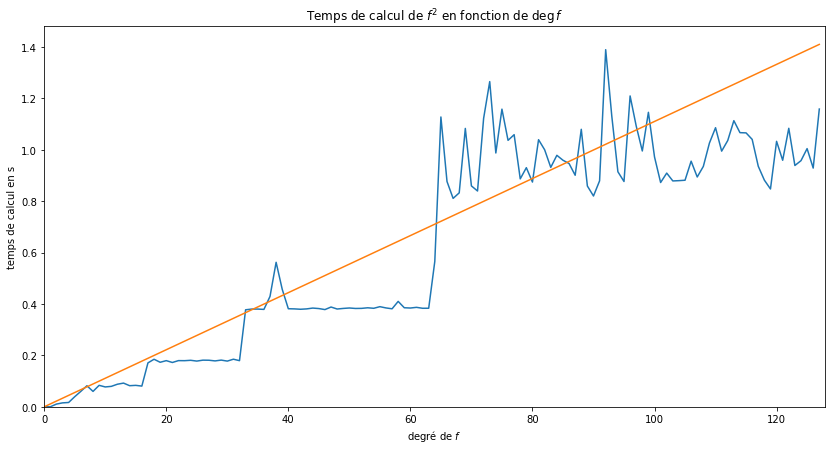

In [48]:
ff = sum([X**i for i in range(2**(n-1))])
liste_deg = range(2**(n-1))
liste_tps = np.zeros(2**(n-1))
for i in tqdm(range(2**(n-1))):
    gg = ff % X**i
    t0 = time()
    h = produit_eff_2(gg,gg)
    t1 = time()
    liste_tps[i] = t1-t0

ll = max([liste_tps[2**i]/(2**i) for i in range(1,n-1)])

plt.close()
plt.figure(figsize = (14, 7))
plt.plot(liste_deg,liste_tps)
plt.plot(liste_deg, l*liste_deg)
plt.title("Temps de calcul de " + r"$f^2$" +" en fonction de " + r"$\deg \, f$")
plt.xlabel('degré de '+ r'$f$')
plt.ylabel('temps de calcul en s')
plt.xlim(0,2**(n-1))
plt.ylim(ymin = 0)
plt.show()

100%|██████████| 128/128 [03:45<00:00,  1.77s/it]


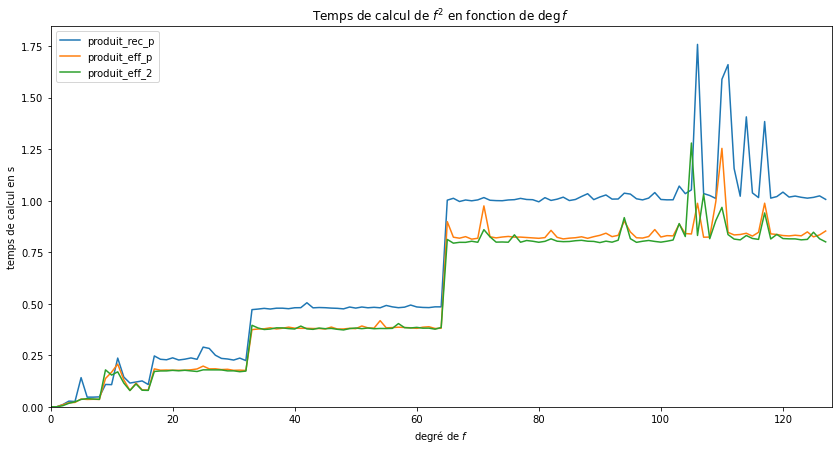

In [58]:
ff = sum([X**i for i in range(2**(n-1))])
liste_deg = range(2**(n-1))
#liste_tps1 = np.zeros(2**(n-1))
liste_tps2 = np.zeros(2**(n-1))
liste_tps3 = np.zeros(2**(n-1))
liste_tps4 = np.zeros(2**(n-1))
for i in tqdm(range(2**(n-1))):
    gg = ff % X**i
    #t0 = time()
    #h1 = multiplication_rec_p(gg,gg)
    t1 = time()
    h2 = produit_rec_p(gg,gg)
    t2 = time()
    h3 = produit_eff_p (gg,gg)
    t3 = time()
    h4 = produit_eff_2 (gg,gg)
    t4 = time()
    liste_tps1[i] = t1-t0
    liste_tps2[i] = t2-t1
    liste_tps3[i] = t3-t2
    liste_tps4[i] = t4-t3


plt.close()
plt.figure(figsize = (14, 7))

#plt.plot(liste_deg,liste_tps1, label = "multiplication_rec_p")
plt.plot(liste_deg,liste_tps2, label = "produit_rec_p")
plt.plot(liste_deg,liste_tps3, label = "produit_eff_p")
plt.plot(liste_deg,liste_tps4, label = "produit_eff_2")

plt.title("Temps de calcul de " + r"$f^2$" +" en fonction de " + r"$\deg \, f$")
plt.xlabel('degré de '+ r'$f$')
plt.ylabel('temps de calcul en s')
plt.legend()
plt.xlim(0,2**(n-1))
plt.ylim(ymin = 0)
plt.show()

100%|██████████| 128/128 [00:00<00:00, 83442.79it/s]


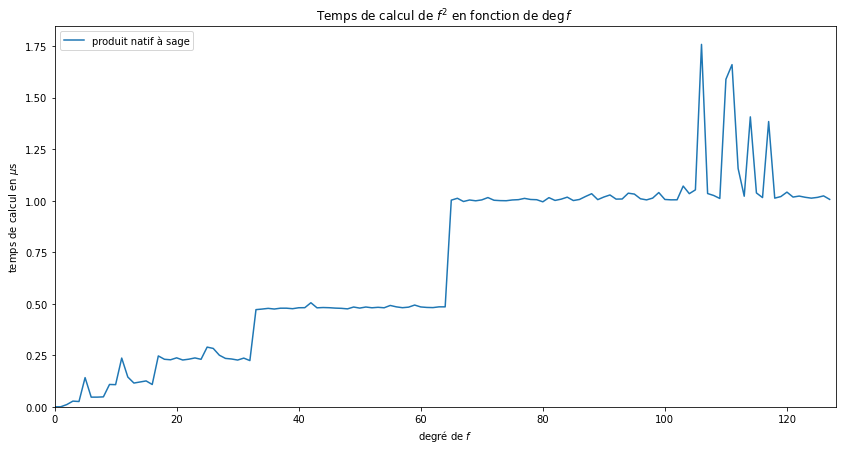

In [62]:
ff = sum([X**i for i in range(2**(n-1))])
liste_deg = range(2**(n-1))
liste_tps = np.zeros(2**(n-1))
for i in tqdm(range(2**(n-1))):
    gg = ff % X**i
    t0 = time()
    h1 = gg*gg
    t1 = time()
    liste_tps[i] = t1-t0


plt.close()
plt.figure(figsize = (14, 7))

#plt.plot(liste_deg,liste_tps1, label = "multiplication_rec_p")
plt.plot(liste_deg,liste_tps2, label = "produit natif à sage")

plt.title("Temps de calcul de " + r"$f^2$" +" en fonction de " + r"$\deg \, f$")
plt.xlabel('degré de '+ r'$f$')
plt.ylabel('temps de calcul en '+r'$\mu$'+'s')
plt.legend()
plt.xlim(0,2**(n-1))
plt.ylim(ymin = 0)
plt.show()

On remarque que le temps est juste divisé par $1 \, 000 \, 000$, mais que la courbe est la mêm.echef cliff

## Étude rapide de la complexité du produit de deux polynômes.